# Johdatus todennäköisyyteen ja tilastotieteeseen
Tässä muistikirjassa käsittelemme joitakin aiemmin keskusteltuja käsitteitä. Monet todennäköisyyden ja tilastotieteen käsitteet ovat hyvin edustettuina suurissa Pythonin datankäsittelykirjastoissa, kuten `numpy` ja `pandas`.


In [117]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

## Satunnaismuuttujat ja jakaumat
Aloitetaan ottamalla 30 arvon otos tasaisesta jakaumasta välillä 0–9. Lasketaan myös keskiarvo ja varianssi.


In [118]:
sample = [ random.randint(0,10) for _ in range(30) ]
print(f"Sample: {sample}")
print(f"Mean = {np.mean(sample)}")
print(f"Variance = {np.var(sample)}")

Sample: [0, 8, 1, 0, 7, 4, 3, 3, 6, 7, 1, 0, 6, 3, 1, 5, 9, 2, 4, 2, 5, 6, 8, 7, 1, 9, 8, 2, 3, 7]
Mean = 4.266666666666667
Variance = 8.195555555555556


Arvioidaksemme visuaalisesti, kuinka monta eri arvoa näytteessä on, voimme piirtää **histogrammin**:


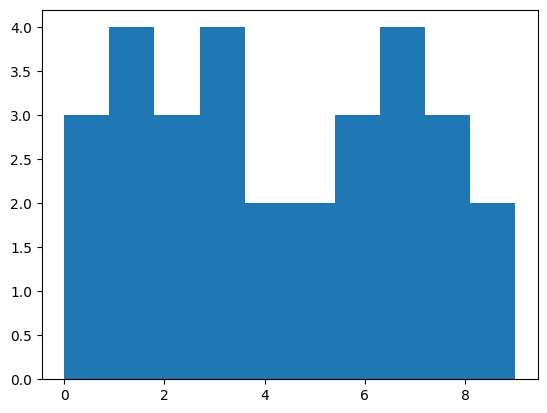

In [119]:
plt.hist(sample)
plt.show()

## Todellisen datan analysointi

Keskiarvo ja varianssi ovat erittäin tärkeitä todellisen maailman datan analysoinnissa. Ladataan tiedot baseball-pelaajista [SOCR MLB Height/Weight Data](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights) -sivustolta.


In [120]:
df = pd.read_csv("../../data/SOCR_MLB.tsv",sep='\t', header=None, names=['Name','Team','Role','Weight','Height','Age'])
df


Empty DataFrame
Columns: [Name, Team, Role, Weight, Height, Age]
Index: []


> Käytämme tässä data-analyysiin pakettia nimeltä [**Pandas**](https://pandas.pydata.org/). Puhumme Pandasista ja datan käsittelystä Pythonissa tarkemmin myöhemmin tässä kurssissa.

Lasketaan keskiarvot iälle, pituudelle ja painolle:


In [121]:
df[['Age','Height','Weight']].mean()

Age        28.736712
Height    201.726306
Weight     73.697292
dtype: float64

Keskitytään nyt pituuteen ja lasketaan keskihajonta ja varianssi:


In [122]:
print(list(df['Height'])[:20])

[180, 215, 210, 210, 188, 176, 209, 200, 231, 180, 188, 180, 185, 160, 180, 185, 197, 189, 185, 219]


In [123]:
mean = df['Height'].mean()
var = df['Height'].var()
std = df['Height'].std()
print(f"Mean = {mean}\nVariance = {var}\nStandard Deviation = {std}")

Mean = 201.72630560928434
Variance = 441.6355706557866
Standard Deviation = 21.01512718628623


Keskiarvon lisäksi on järkevää tarkastella mediaaniarvoa ja kvartiileja. Ne voidaan visualisoida käyttämällä **laatikko-viiksikaaviota**:


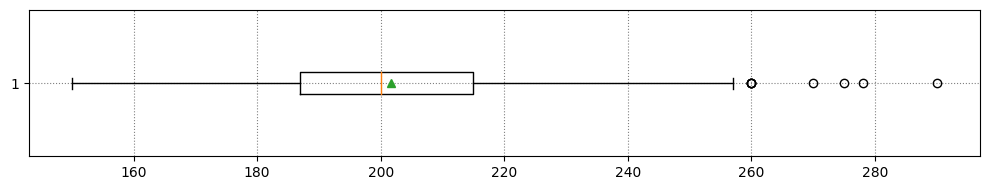

In [124]:
plt.figure(figsize=(10,2))
plt.boxplot(df['Height'], vert=False, showmeans=True)
plt.grid(color='gray', linestyle='dotted')
plt.tight_layout()
plt.show()

Voimme myös tehdä laatikkokaavioita tietojoukon osajoukoista, esimerkiksi ryhmiteltynä pelaajan roolin mukaan.


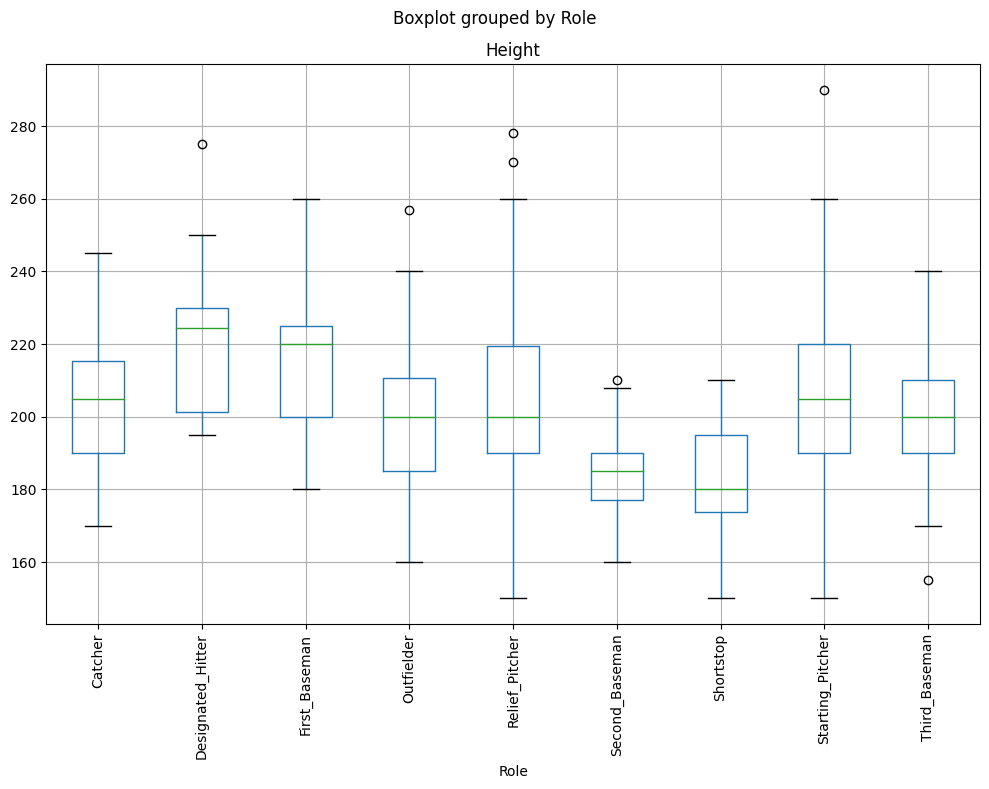

In [125]:
df.boxplot(column='Height', by='Role', figsize=(10,8))
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

> **Huomio**: Tämä kaavio viittaa siihen, että keskimäärin ensimmäisen pesän pelaajien pituudet ovat suurempia kuin toisen pesän pelaajien pituudet. Myöhemmin opimme, kuinka voimme testata tätä hypoteesia tarkemmin ja osoittaa, että datamme on tilastollisesti merkittävää tämän osoittamiseksi.  

Ikä, pituus ja paino ovat kaikki jatkuvia satunnaismuuttujia. Mitä luulet niiden jakauman olevan? Hyvä tapa selvittää tämä on piirtää arvojen histogrammi:


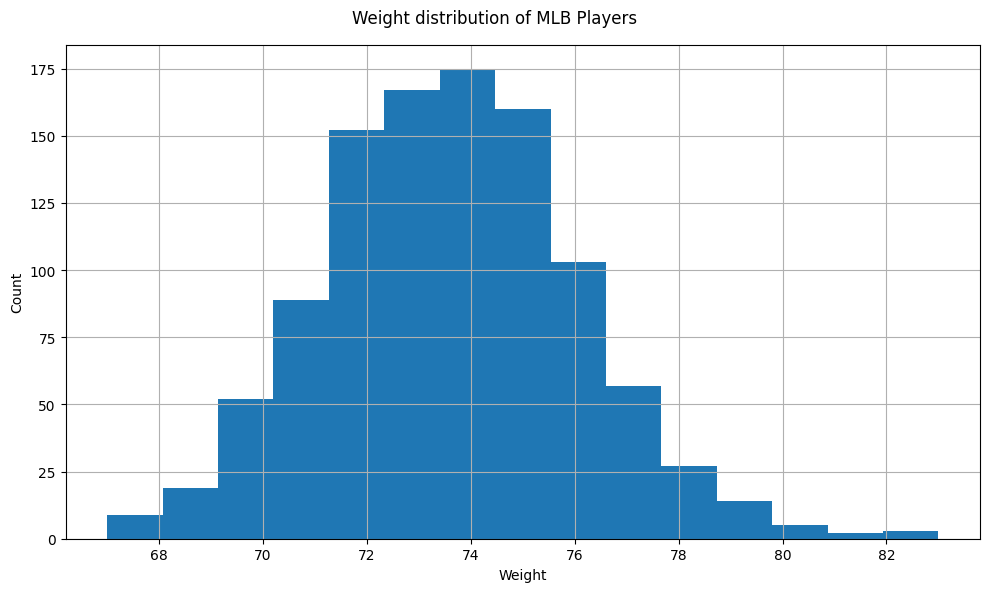

In [126]:
df['Weight'].hist(bins=15, figsize=(10,6))
plt.suptitle('Weight distribution of MLB Players')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Normaalijakauma

Luodaan keinotekoinen painonäyte, joka noudattaa normaalijakaumaa ja jolla on sama keskiarvo ja varianssi kuin todellisella datallamme:


In [127]:
generated = np.random.normal(mean, std, 1000)
generated[:20]

array([183.05261872, 193.52828463, 154.73707302, 204.27140391,
       203.88907247, 213.74665656, 225.10092364, 171.75867917,
       204.3521425 , 207.52870255, 158.53001756, 240.94399197,
       189.9909742 , 180.72442994, 173.4393402 , 175.98883711,
       197.86092769, 188.61598821, 234.19796698, 209.0295457 ])

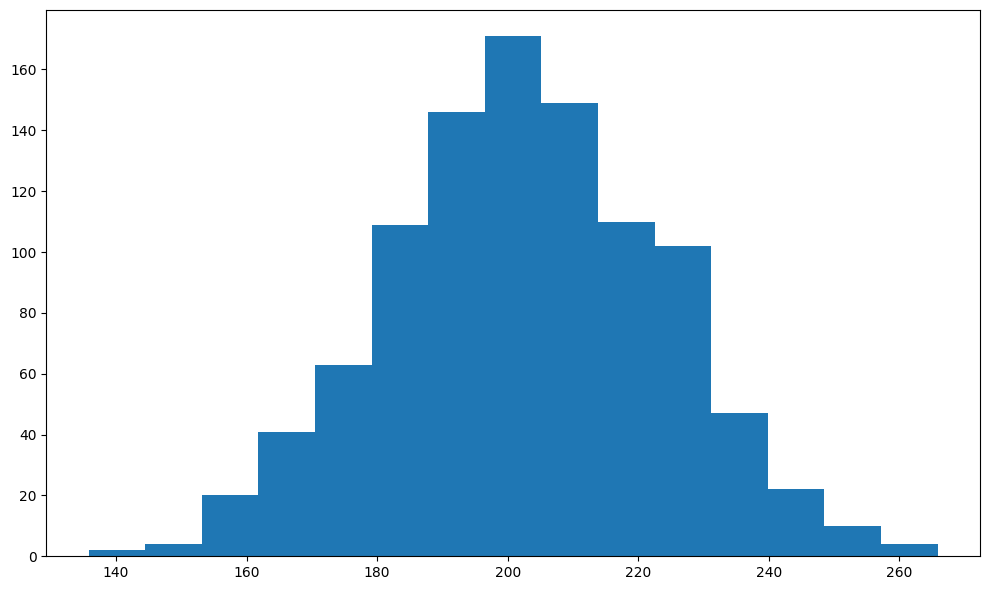

In [128]:
plt.figure(figsize=(10,6))
plt.hist(generated, bins=15)
plt.tight_layout()
plt.show()

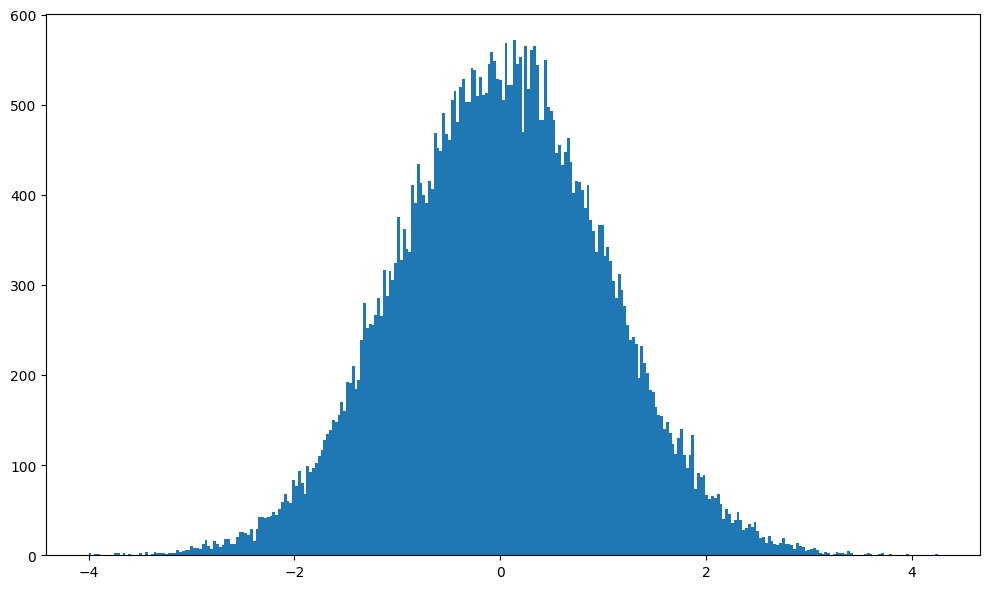

In [129]:
plt.figure(figsize=(10,6))
plt.hist(np.random.normal(0,1,50000), bins=300)
plt.tight_layout()
plt.show()

Koska useimmat arvot tosielämässä ovat normaalijakautuneita, meidän ei pitäisi käyttää tasaista satunnaislukugeneraattoria näyteaineiston luomiseen. Tässä on, mitä tapahtuu, jos yritämme luoda painoja tasaisella jakaumalla (luotu `np.random.rand`-funktiolla):


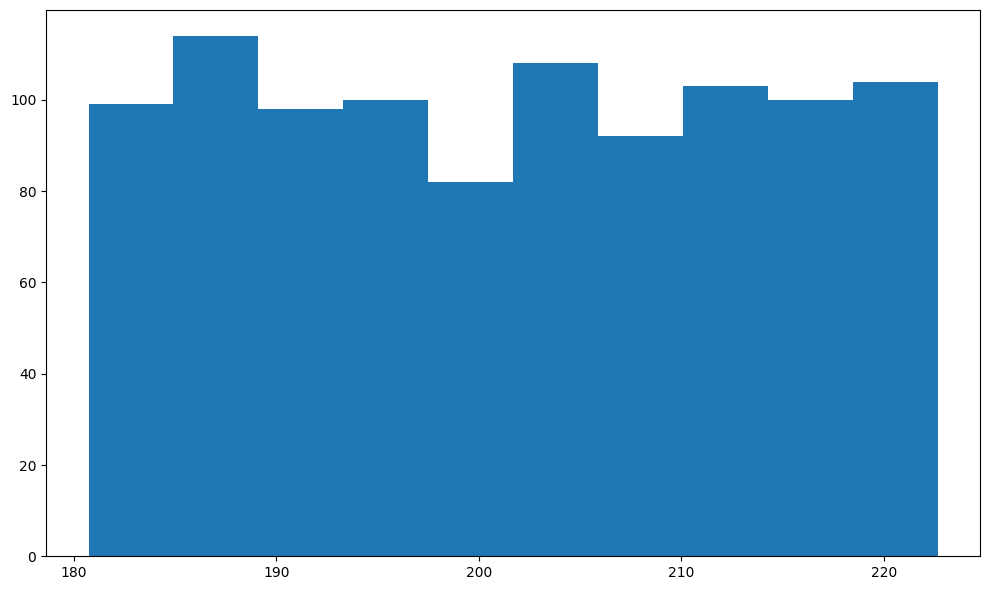

In [130]:
wrong_sample = np.random.rand(1000)*2*std+mean-std
plt.figure(figsize=(10,6))
plt.hist(wrong_sample)
plt.tight_layout()
plt.show()

## Luottamusvälit

Lasketaan nyt luottamusvälit baseball-pelaajien painoille ja pituuksille. Käytämme koodia [tästä Stack Overflow -keskustelusta](https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data):


In [131]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

for p in [0.85, 0.9, 0.95]:
    m, h = mean_confidence_interval(df['Weight'].fillna(method='pad'),p)
    print(f"p={p:.2f}, mean = {m:.2f} ± {h:.2f}")

p=0.85, mean = 73.70 ± 0.10
p=0.90, mean = 73.70 ± 0.12
p=0.95, mean = 73.70 ± 0.14


## Hypoteesin testaus

Tutkitaan eri rooleja baseball-pelaajien aineistossamme:


In [132]:
df.groupby('Role').agg({ 'Weight' : 'mean', 'Height' : 'mean', 'Age' : 'count'}).rename(columns={ 'Age' : 'Count'})

Weight      Height  Count
Role                                           
Catcher            72.723684  204.328947     76
Designated_Hitter  74.222222  220.888889     18
First_Baseman      74.000000  213.109091     55
Outfielder         73.010309  199.113402    194
Relief_Pitcher     74.374603  203.517460    315
Second_Baseman     71.362069  184.344828     58
Shortstop          71.903846  182.923077     52
Starting_Pitcher   74.719457  205.321267    221
Third_Baseman      73.044444  200.955556     45

In [133]:
for p in [0.85,0.9,0.95]:
    m1, h1 = mean_confidence_interval(df.loc[df['Role']=='First_Baseman',['Height']],p)
    m2, h2 = mean_confidence_interval(df.loc[df['Role']=='Second_Baseman',['Height']],p)
    print(f'Conf={p:.2f}, 1st basemen height: {m1-h1[0]:.2f}..{m1+h1[0]:.2f}, 2nd basemen height: {m2-h2[0]:.2f}..{m2+h2[0]:.2f}')

Conf=0.85, 1st basemen height: 209.36..216.86, 2nd basemen height: 182.24..186.45
Conf=0.90, 1st basemen height: 208.82..217.40, 2nd basemen height: 181.93..186.76
Conf=0.95, 1st basemen height: 207.97..218.25, 2nd basemen height: 181.45..187.24


Voimme nähdä, että välejä ei ole päällekkäin.

Tilastollisesti tarkempi tapa todistaa hypoteesi on käyttää **Studentin t-testiä**:


In [134]:
from scipy.stats import ttest_ind

tval, pval = ttest_ind(df.loc[df['Role']=='First_Baseman',['Height']], df.loc[df['Role']=='Second_Baseman',['Height']],equal_var=False)
print(f"T-value = {tval[0]:.2f}\nP-value: {pval[0]}")

T-value = 9.77
P-value: 1.4185554184322326e-15


`ttest_ind`-funktion palauttamat kaksi arvoa ovat:
* p-arvo voidaan pitää todennäköisyytenä, että kahdella jakaumalla on sama keskiarvo. Meidän tapauksessamme se on hyvin matala, mikä tarkoittaa, että on vahvaa näyttöä siitä, että ensimmäisen pesän pelaajat ovat pidempiä.
* t-arvo on normalisoidun keskiarvoeron väliarvo, jota käytetään t-testissä, ja sitä verrataan kynnysarvoon tietyn luottamusarvon perusteella.


## Normaalijakauman simulointi keskeisen raja-arvolauseen avulla

Pythonin pseudorandom-generaattori on suunniteltu tuottamaan tasajakauman. Jos haluamme luoda generaattorin normaalijakaumalle, voimme hyödyntää keskeistä raja-arvolausetta. Saadaksemme normaalijakautuneen arvon, laskemme vain tasajakaumasta tuotetun otoksen keskiarvon.


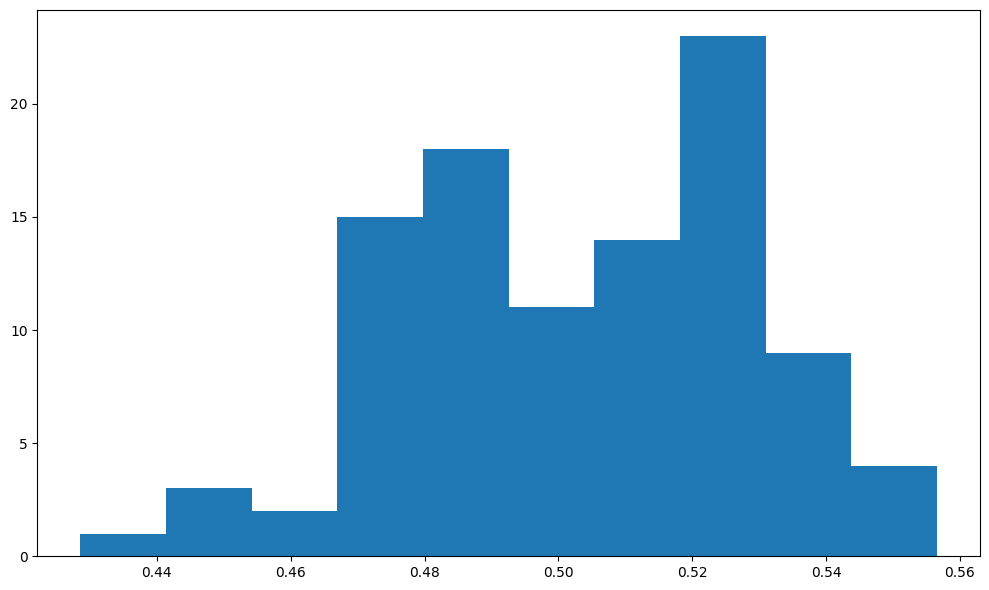

In [135]:
def normal_random(sample_size=100):
    sample = [random.uniform(0,1) for _ in range(sample_size) ]
    return sum(sample)/sample_size

sample = [normal_random() for _ in range(100)]
plt.figure(figsize=(10,6))
plt.hist(sample)
plt.tight_layout()
plt.show()

## Korrelaatio ja Paha Baseball-yhtiö

Korrelaation avulla voimme löytää yhteyksiä datasekvenssien välillä. Kuvitellaanpa esimerkkinä, että on olemassa paha baseball-yhtiö, joka maksaa pelaajilleen palkkaa heidän pituutensa mukaan – mitä pidempi pelaaja, sitä enemmän rahaa hän saa. Oletetaan, että peruspalkka on $1000, ja lisäksi korkeintaan $100 bonus, joka riippuu pelaajan pituudesta. Käytämme oikeita MLB-pelaajia ja laskemme heidän kuvitteelliset palkkansa:


In [136]:
heights = df['Height']
salaries = 1000+(heights-heights.min())/(heights.max()-heights.mean())*100
print(list(zip(heights, salaries))[:10])

[(180, 1033.985209531635), (215, 1073.6346206518763), (210, 1067.9704190632704), (210, 1067.9704190632704), (188, 1043.0479320734046), (176, 1029.4538482607504), (209, 1066.837578745549), (200, 1056.6420158860585), (231, 1091.760065735415), (180, 1033.985209531635)]


Lasketaan nyt näiden sekvenssien kovarianssi ja korrelaatio. `np.cov` antaa meille niin sanotun **kovarianssimatriisin**, joka on kovarianssin laajennus usealle muuttujalle. Kovarianssimatriisin $M$ alkio $M_{ij}$ on syötemuuttujien $X_i$ ja $X_j$ välinen korrelaatio, ja diagonaaliarvot $M_{ii}$ ovat $X_{i}$ varianssi. Vastaavasti `np.corrcoef` antaa meille **korrelaatiomatriisin**.


In [137]:
print(f"Covariance matrix:\n{np.cov(heights, salaries)}")
print(f"Covariance = {np.cov(heights, salaries)[0,1]}")
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Covariance matrix:
[[441.63557066 500.30258018]
 [500.30258018 566.76293389]]
Covariance = 500.3025801786725
Correlation = 0.9999999999999997


Korrelaatio, joka on yhtä kuin 1, tarkoittaa, että kahden muuttujan välillä on vahva **lineaarinen yhteys**. Voimme nähdä lineaarisen yhteyden visuaalisesti piirtämällä yhden arvon toista vastaan:


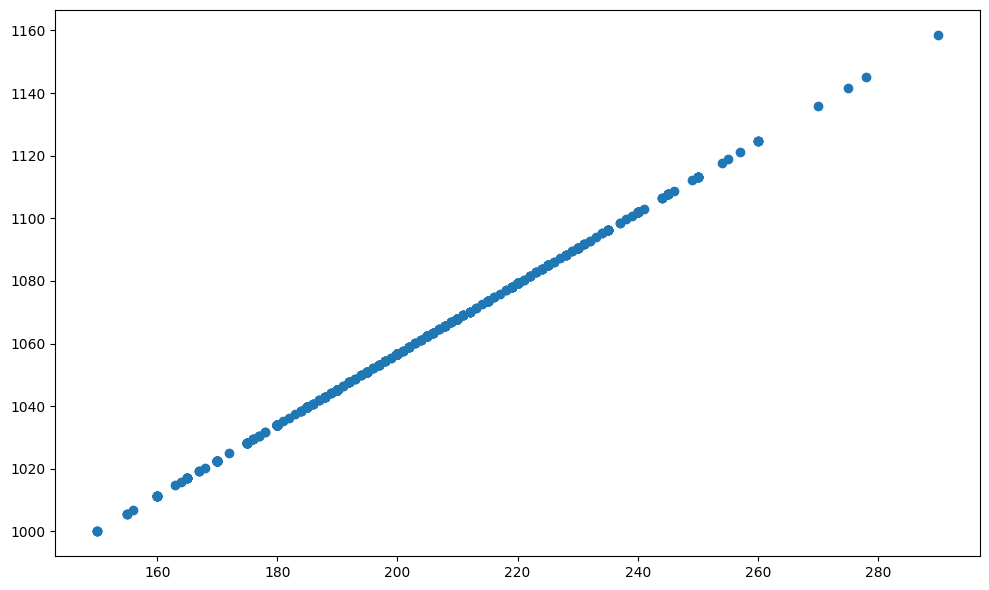

In [138]:
plt.figure(figsize=(10,6))
plt.scatter(heights,salaries)
plt.tight_layout()
plt.show()

Katsotaanpa, mitä tapahtuu, jos riippuvuus ei ole lineaarinen. Oletetaan, että yrityksemme päätti piilottaa ilmeisen lineaarisen riippuvuuden pituuksien ja palkkojen välillä ja lisäsi kaavaan jonkin epälineaarisuuden, kuten `sin`:


In [139]:
salaries = 1000+np.sin((heights-heights.min())/(heights.max()-heights.mean()))*100
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Correlation = 0.9910655775558532


Tässä tapauksessa korrelaatio on hieman pienempi, mutta se on silti melko korkea. Nyt, jotta suhde olisi vielä vähemmän ilmeinen, voisimme lisätä hieman ylimääräistä satunnaisuutta lisäämällä satunnaisen muuttujan palkkaan. Katsotaanpa, mitä tapahtuu:


In [140]:
salaries = 1000+np.sin((heights-heights.min())/(heights.max()-heights.mean()))*100+np.random.random(size=len(heights))*20-10
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Correlation = 0.948230287835537


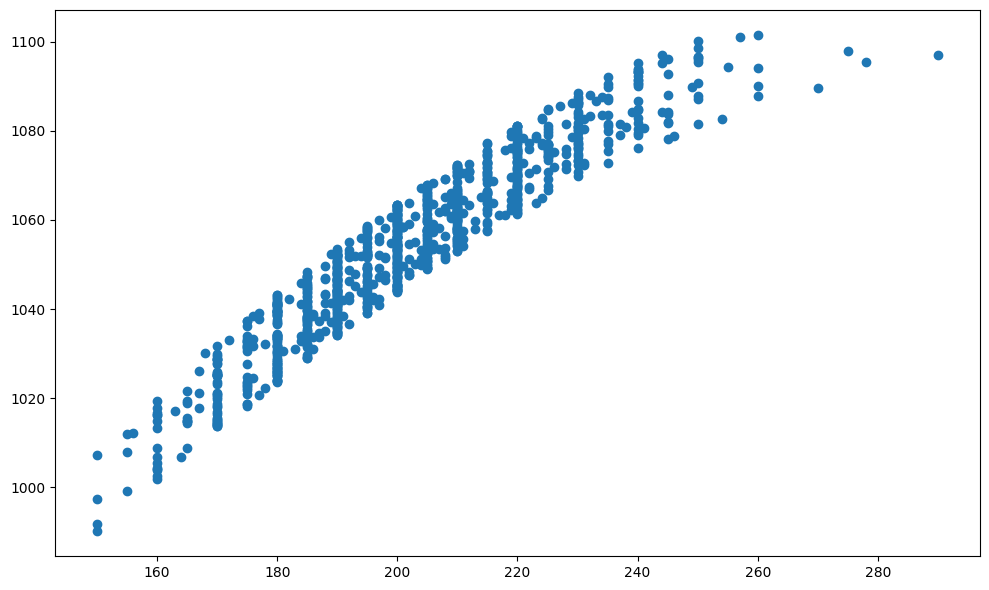

In [141]:
plt.figure(figsize=(10,6))
plt.scatter(heights, salaries)
plt.tight_layout()
plt.show()

> Voitko arvata, miksi pisteet asettuvat pystysuoriin linjoihin tällä tavalla?

Olemme havainneet korrelaation keinotekoisesti luodun käsitteen, kuten palkan, ja havaitun muuttujan *pituus* välillä. Katsotaanpa myös, korreloivatko kaksi havaittua muuttujaa, kuten pituus ja paino, keskenään:


In [142]:
np.corrcoef(df['Height'],df['Weight'])

array([[1.        , 0.52959196],
       [0.52959196, 1.        ]])

Valitettavasti emme saaneet mitään tuloksia - vain joitakin outoja `nan`-arvoja. Tämä johtuu siitä, että jotkut sarjan arvot ovat määrittelemättömiä, edustettuina `nan`-arvoina, mikä aiheuttaa sen, että operaation tuloskin on määrittelemätön. Tarkastelemalla matriisia voimme nähdä, että `Weight`-sarake on ongelmallinen, koska `Height`-arvojen keskinäinen korrelaatio on laskettu.

> Tämä esimerkki korostaa **datan valmistelun** ja **puhdistamisen** merkitystä. Ilman asianmukaista dataa emme voi laskea mitään.

Käytetään `fillna`-metodia puuttuvien arvojen täyttämiseen ja lasketaan korrelaatio:


In [143]:
np.corrcoef(df['Height'],df['Weight'].fillna(method='pad'))

array([[1.        , 0.52959196],
       [0.52959196, 1.        ]])

On todellakin korrelaatio, mutta ei niin vahva kuin keinotekoisessa esimerkissämme. Itse asiassa, jos tarkastelemme hajontakaaviota, jossa yksi arvo on toista vastaan, yhteys olisi paljon vähemmän ilmeinen:


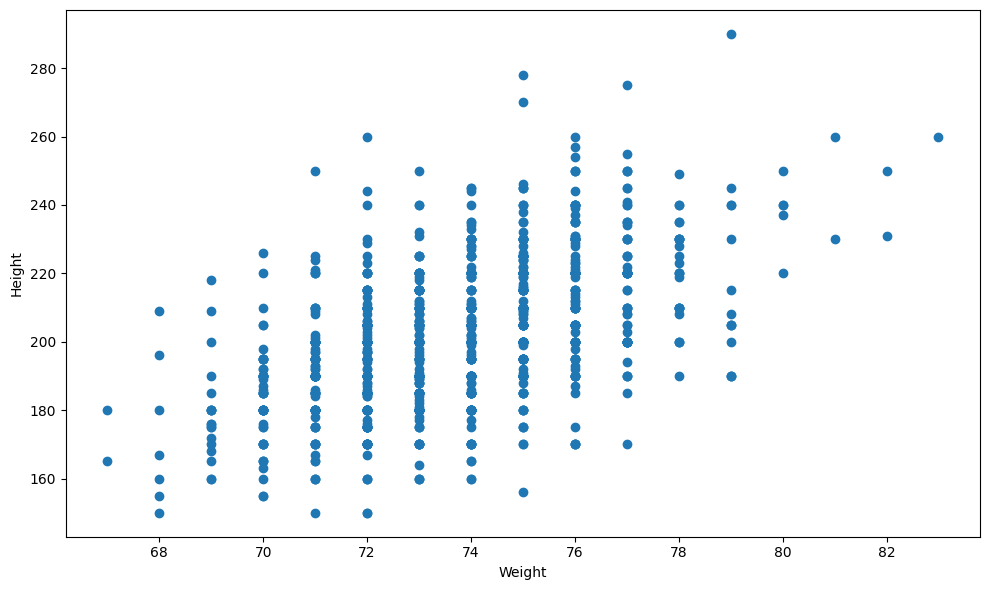

In [144]:
plt.figure(figsize=(10,6))
plt.scatter(df['Weight'],df['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

## Yhteenveto

Tässä muistikirjassa olemme oppineet suorittamaan perusoperaatioita datalla tilastollisten funktioiden laskemiseksi. Nyt tiedämme, kuinka käyttää vankkaa matematiikan ja tilastotieteen välineistöä hypoteesien todistamiseen sekä kuinka laskea luottamusvälejä satunnaisille muuttujille annetun otoksen perusteella.



---

**Vastuuvapauslauseke**:  
Tämä asiakirja on käännetty käyttämällä tekoälypohjaista käännöspalvelua [Co-op Translator](https://github.com/Azure/co-op-translator). Vaikka pyrimme tarkkuuteen, huomioithan, että automaattiset käännökset voivat sisältää virheitä tai epätarkkuuksia. Alkuperäistä asiakirjaa sen alkuperäisellä kielellä tulee pitää ensisijaisena lähteenä. Kriittisen tiedon osalta suositellaan ammattimaista ihmiskääntämistä. Emme ole vastuussa tämän käännöksen käytöstä aiheutuvista väärinkäsityksistä tai virhetulkinnoista.
